In [1]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from xgboost import XGBClassifier
from sklearn.ensemble import (
    RandomForestClassifier, 
    AdaBoostClassifier,
    GradientBoostingClassifier
)
from sklearn.model_selection import train_test_split
from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import StratifiedKFold, cross_val_score, GridSearchCV, learning_curve
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
from sklearn.metrics import roc_auc_score, average_precision_score, make_scorer
from sklearn.metrics import classification_report, roc_curve, precision_recall_curve, auc
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay

# 5. Model Training

In [2]:
# Load individual train and test dataset arrays
train_array = np.load('train_array.npy')
test_array = np.load('test_array.npy')

In [3]:
X_train, y_train, X_test, y_test = (
    train_array[:, :-1],
    train_array[:, -1].astype(int),  # Convert y_train to integer
    test_array[:, :-1],
    test_array[:, -1].astype(int)   # Convert y_test to integer
)

In [4]:
print(X_train[:5])
print(y_train[:5])

[[-1.13072593e-01  2.50000000e-05  2.50000000e-05  0.00000000e+00
   1.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 7.32170486e+00  2.50000000e-05  2.50000000e-05  1.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 6.10589071e-02  2.50000000e-05  2.50000000e-05  0.00000000e+00
   0.00000000e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   1.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 8.68951820e+00  2.50000000e-05  1.00000000e-04  0.00000000e+00
   0.00000000e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
   0.00000000e+00  

### Base Model

In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

param_grid = {
    'C': [0.1, 1, 10],  # Regularization strength
    'solver': ['liblinear', 'lbfgs']  # Solvers compatible with smaller datasets
}

log_reg = LogisticRegression(random_state=42, max_iter=1000)

grid_search = GridSearchCV(
    estimator=log_reg,
    param_grid=param_grid,
    cv=2,
    verbose=2
)

grid_search.fit(X_train, y_train)

print("Best Parameters: ", grid_search.best_params_)

best_model = grid_search.best_estimator_

# Predict on Train data
y_train_pred = best_model.predict(X_train)
# Predict on Test data
y_test_pred = best_model.predict(X_test)

print(f"Precision: {precision_score(y_test, y_test_pred, average='weighted')}")
print(f"Recall: {recall_score(y_test, y_test_pred, average='weighted')}")
print(f"F1 score: {f1_score(y_test, y_test_pred, average='weighted')}")
# Compute confusion matrix
print(f"Confusion Matrix: \n{confusion_matrix(y_test, y_test_pred)}")

   

Fitting 2 folds for each of 6 candidates, totalling 12 fits
[CV] END ............................C=0.1, solver=liblinear; total time=   0.0s
[CV] END ............................C=0.1, solver=liblinear; total time=   0.0s
[CV] END ................................C=0.1, solver=lbfgs; total time=   0.0s
[CV] END ................................C=0.1, solver=lbfgs; total time=   0.0s
[CV] END ..............................C=1, solver=liblinear; total time=   0.0s
[CV] END ..............................C=1, solver=liblinear; total time=   0.0s
[CV] END ..................................C=1, solver=lbfgs; total time=   0.1s
[CV] END ..................................C=1, solver=lbfgs; total time=   0.0s
[CV] END .............................C=10, solver=liblinear; total time=   0.0s
[CV] END .............................C=10, solver=liblinear; total time=   0.0s
[CV] END .................................C=10, solver=lbfgs; total time=   0.0s
[CV] END .................................C=10, s

#### Oversamplig the data and cross validating by using different models


In [6]:
"""  Imbalance dataset - upsampling """
def upsampling_data(X, y):
    sm = SMOTE(sampling_strategy='auto', random_state=42)
    X_sm, y_sm = sm.fit_resample(X, y) 
    # # Check that the minority class is present in the resampled data
    # if 1 not in y_sm:
    #     print("Warning: SMOTE failed to generate minority class samples. Returning original data.")
    #     return X, y  # Return original data if SMOTE fails 
    print(f"\n====== Upsampled the minority class data ======") 
    print("Before SMOTE: ", Counter(y))
    print("After SMOTE: ", Counter(y_sm))
    return X_sm, y_sm


""" Evaluating Models """
# def model_evaluation(model, X, y, num_procs):
#     # parallel cross-validate models
#     print("\n===================== Beginning cross validation ========================== ")
#     # Define cross-validation method
#     cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
#     # Define metrics
#     metrics = {
#         'Precision': make_scorer(precision_score, average='weighted'),
#         'Recall': make_scorer(recall_score, average='weighted'),
#         'F1 score': make_scorer(f1_score, average='weighted')
#     }
#     # Perform cross-validation and evaluate using different metrics
#     metrics_results = {}
#     for name, metric in metrics.items():
#         scores = cross_val_score(model, X, y, cv=cv, scoring=metric).mean()
#         metrics_results[name] = scores
#     return metrics_results


""" Calculate Metrics """
def model_metrics(y_test, y_pred, y_pred_proba=None):
    
    # Convert to int to ensure compatibility
    y_test = y_test.astype(int)
    y_pred = y_pred.astype(int)

    # Calculate precision, recall, F1 score, and confusion matrix
    precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='weighted')
    cm = confusion_matrix(y_test, y_pred)

    # Calculate ROC AUC and PR AUC if predicted probabilities are provided
    roc_auc, pr_auc = np.nan, np.nan  # Default values
    if y_pred_proba is not None:
        try:
            # Check if both classes are present in y_test
            if len(np.unique(y_test)) == 1:
                print("Only one class present in y_test, skipping ROC AUC and PR AUC.")
            else:
                # Calculate ROC AUC
                roc_auc = roc_auc_score(y_test, y_pred_proba)
                
                # Calculate PR AUC
                precision_pr, recall_pr, _ = precision_recall_curve(y_test, y_pred_proba)
                pr_auc = auc(recall_pr, precision_pr)
        except Exception as e:
            print(f"Error calculating ROC AUC or PR AUC: {e}. Returning NaN for these metrics.")
    
    # Return all metrics
    if y_pred_proba is not None:
        return precision, recall, f1, cm, roc_auc, pr_auc
    else:
        return precision, recall, f1, cm

#### Learning Curve

In [7]:
# Learning curve function
def plot_learning_curve(model, X, y, title, train_sizes=np.linspace(0.1, 1.0, 10)):
    """
    Plots the learning curve for a given model, showing how precision and recall
    change as the size of the training dataset increases.

    Parameters:
        model: The machine learning model to evaluate.
        X: Features of the dataset.
        y: Labels of the dataset.
        title: Title for the learning curve plot.
        cv: Number of cross-validation folds (default: 5).
        train_sizes: Proportion of the training set to use for learning curve (default: 10 increments from 10% to 100%).
    """
    
    # Define scoring metrics for precision and recall
    scoring_metrics = {
        "precision": make_scorer(precision_score, average='weighted', zero_division=0),  # Precision scorer for the positive class
        "recall": make_scorer(recall_score, average='weighted', zero_division=0)        # Recall scorer for the positive class
    }
    
    # Create subplots for precision and recall learning curves
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))  # 1 row, 2 columns for precision and recall
    fig.suptitle(title)  # Set the main title for the figure
    
    # Initialize StratifiedKFold
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    # Loop through each metric (precision and recall)
    for i, (metric_name, scoring) in enumerate(scoring_metrics.items()):
        # Compute the learning curve for the current metric
        train_sizes, train_scores, val_scores = learning_curve(
            estimator=model,  # The model to evaluate
            X=X,              # Features
            y=y,              # Labels
            cv=skf,            # Cross-validation folds
            scoring=scoring,  # Scoring metric (precision or recall)
            train_sizes=train_sizes,  # Proportion of training set to use
            n_jobs=-1,        # Use all available CPU cores
            verbose=1         # Show progress
        )
        
        # Calculate mean and standard deviation of training and validation scores
        train_scores_mean = np.mean(train_scores, axis=1)  # Mean training score across folds
        train_scores_std = np.std(train_scores, axis=1)    # Standard deviation of training scores
        val_scores_mean = np.mean(val_scores, axis=1)      # Mean validation score across folds
        val_scores_std = np.std(val_scores, axis=1)        # Standard deviation of validation scores
        
        # Set subplot title and labels
        axes[i].set_title(f"{metric_name.capitalize()} Learning Curve")  # Subplot title
        axes[i].set_xlabel("Training Examples")                         # X-axis label
        axes[i].set_ylabel(f"{metric_name.capitalize()} Score")          # Y-axis label
        axes[i].grid()  # Add grid lines for better readability
        
        # Plot the training scores with shaded standard deviation
        axes[i].fill_between(train_sizes, train_scores_mean - train_scores_std,
                             train_scores_mean + train_scores_std, alpha=0.1, color="r")  # Shaded area for training scores
        axes[i].plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training Score")  # Training score line
        
        # Plot the validation scores with shaded standard deviation
        axes[i].fill_between(train_sizes, val_scores_mean - val_scores_std,
                             val_scores_mean + val_scores_std, alpha=0.1, color="g")  # Shaded area for validation scores
        axes[i].plot(train_sizes, val_scores_mean, 'o-', color="g", label="Validation Score")  # Validation score line
        
        # Add legend to the subplot
        axes[i].legend(loc="best")
    
    # Display the learning curve plot
    plt.show()

#### ROC & PR curves

In [8]:

def plot_roc_pr_curves(y_test, y_pred_proba, title_suffix=""):
    """
    Plots ROC curve and Precision-Recall curve with their respective AUC values.

    Parameters:
        y_test (array-like): True labels.
        y_pred_proba (array-like): Predicted probabilities for the positive class.
        title_suffix (str): Suffix to add to the plot titles (e.g., model name).
    """
    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    # Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
    pr_auc = auc(recall, precision)

    # Create subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

    # Plot ROC Curve
    ax1.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
    ax1.plot([0, 1], [0, 1], color='gray', linestyle='--')
    ax1.set_xlabel('False Positive Rate')
    ax1.set_ylabel('True Positive Rate')
    ax1.set_title(f'ROC Curve {title_suffix}')
    ax1.legend(loc='lower right')

    # Plot Precision-Recall Curve
    ax2.plot(recall, precision, color='green', lw=2, label=f'PR Curve (AUC = {pr_auc:.2f})')
    ax2.set_xlabel('Recall')
    ax2.set_ylabel('Precision')
    ax2.set_title(f'Precision-Recall Curve {title_suffix}')
    ax2.legend(loc='upper right')

    plt.tight_layout()
    plt.show()

## Models Evaluation 


================ Random_Forest ==================================

====== Upsampled the minority class data ======
Before SMOTE:  Counter({np.int64(0): 39959, np.int64(1): 41})
After SMOTE:  Counter({np.int64(0): 39959, np.int64(1): 39959})
Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV] END max_depth=None, min_samples_split=2, n_estimators=50; total time=   2.1s
[CV] END max_depth=None, min_samples_split=2, n_estimators=50; total time=   2.1s
[CV] END max_depth=None, min_samples_split=2, n_estimators=50; total time=   2.1s
[CV] END max_depth=None, min_samples_split=2, n_estimators=50; total time=   2.2s
[CV] END max_depth=None, min_samples_split=2, n_estimators=50; total time=   2.2s
[CV] END max_depth=None, min_samples_split=2, n_estimators=100; total time=   4.0s
[CV] END max_depth=None, min_samples_split=2, n_estimators=100; total time=   4.2s
[CV] END max_depth=None, min_samples_split=2, n_estimators=100; total time=   4.3s
[CV] END max_depth=None, min_samples_

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    9.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.


[learning_curve] Training set sizes: [ 6393 12786 19180 25573 31967 38360 44753 51147 57540 63934]


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    9.2s finished


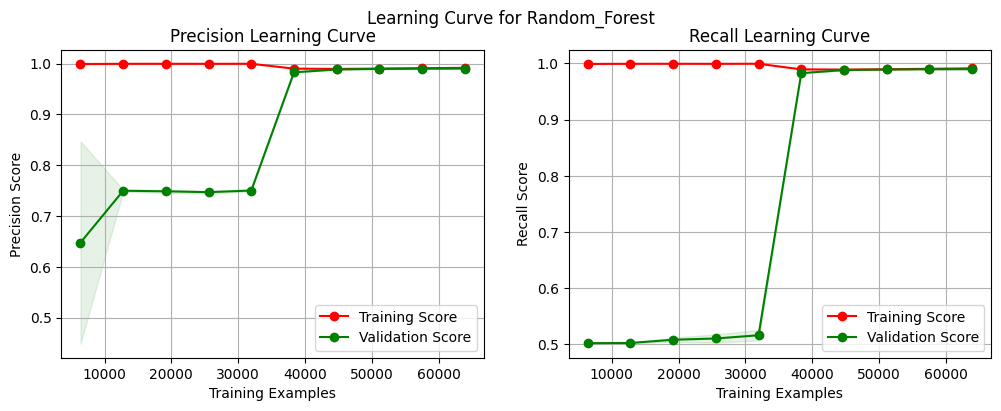

Ploting ROC-AUC and PR-AUC curves


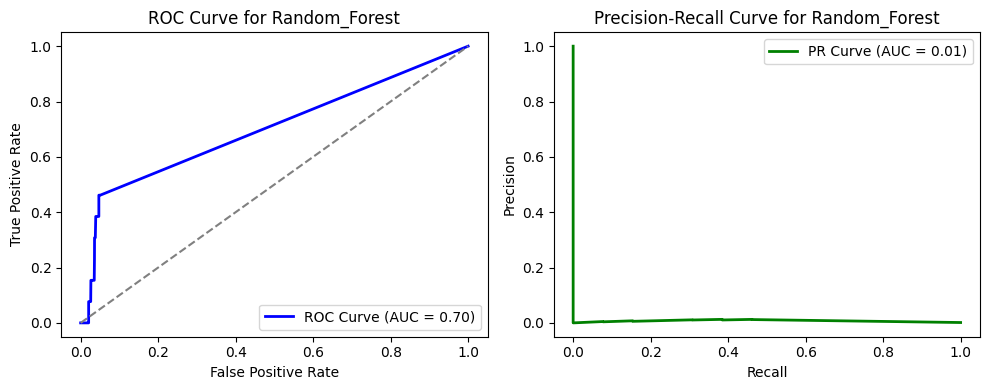




================ AdaBoost ==================================

====== Upsampled the minority class data ======
Before SMOTE:  Counter({np.int64(0): 39959, np.int64(1): 41})
After SMOTE:  Counter({np.int64(0): 39959, np.int64(1): 39959})
Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] END ................learning_rate=0.01, n_estimators=50; total time=   1.6s
[CV] END ................learning_rate=0.01, n_estimators=50; total time=   1.6s
[CV] END ................learning_rate=0.01, n_estimators=50; total time=   1.6s
[CV] END ................learning_rate=0.01, n_estimators=50; total time=   1.7s
[CV] END ................learning_rate=0.01, n_estimators=50; total time=   1.7s
[CV] END ...............learning_rate=0.01, n_estimators=100; total time=   3.1s
[CV] END ...............learning_rate=0.01, n_estimators=100; total time=   3.3s
[CV] END ...............learning_rate=0.01, n_estimators=100; total time=   3.3s
[CV] END ...............learning_rate=0.01, n_estima

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   20.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.


[learning_curve] Training set sizes: [ 6393 12786 19180 25573 31967 38360 44753 51147 57540 63934]


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   19.4s finished


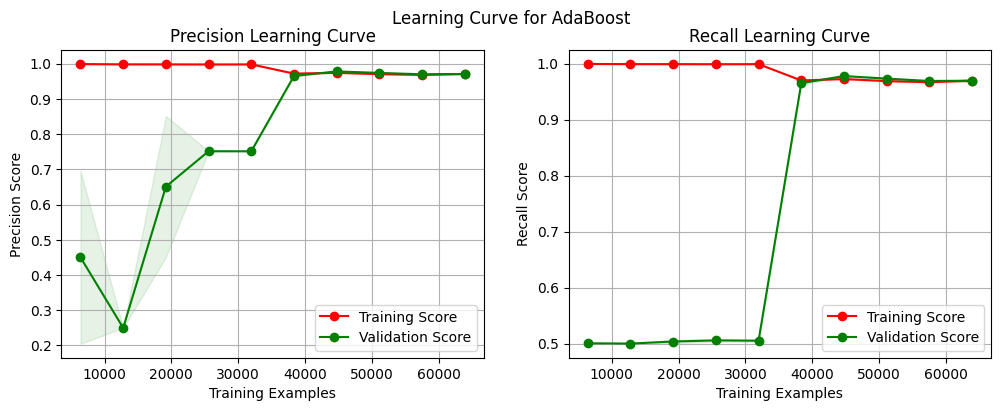

Ploting ROC-AUC and PR-AUC curves


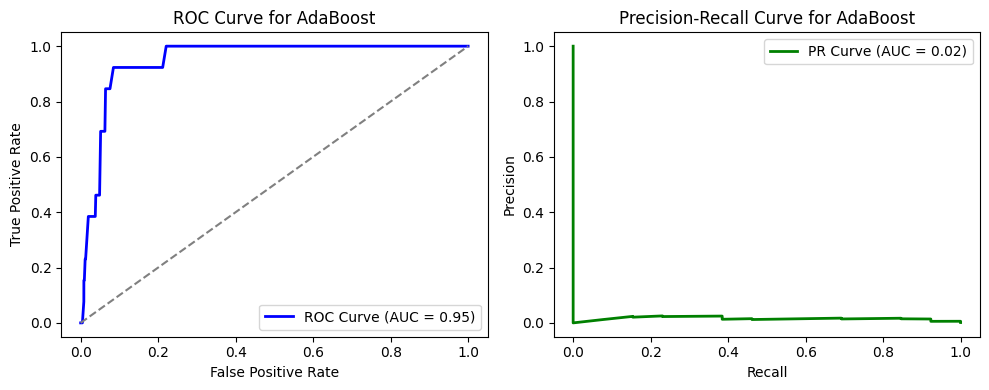




================ XGBoost ==================================

====== Upsampled the minority class data ======
Before SMOTE:  Counter({np.int64(0): 39959, np.int64(1): 41})
After SMOTE:  Counter({np.int64(0): 39959, np.int64(1): 39959})
Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV] END ...learning_rate=0.01, max_depth=3, n_estimators=50; total time=   0.2s
[CV] END ...learning_rate=0.01, max_depth=3, n_estimators=50; total time=   0.2s
[CV] END ...learning_rate=0.01, max_depth=3, n_estimators=50; total time=   0.2s
[CV] END ...learning_rate=0.01, max_depth=3, n_estimators=50; total time=   0.2s
[CV] END ...learning_rate=0.01, max_depth=3, n_estimators=50; total time=   0.2s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=100; total time=   0.3s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=100; total time=   0.3s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=100; total time=   0.3s
[CV] END ..learning_rate=0.01, max_depth=3, n_estima

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    3.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.


[learning_curve] Training set sizes: [ 6393 12786 19180 25573 31967 38360 44753 51147 57540 63934]


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    3.5s finished


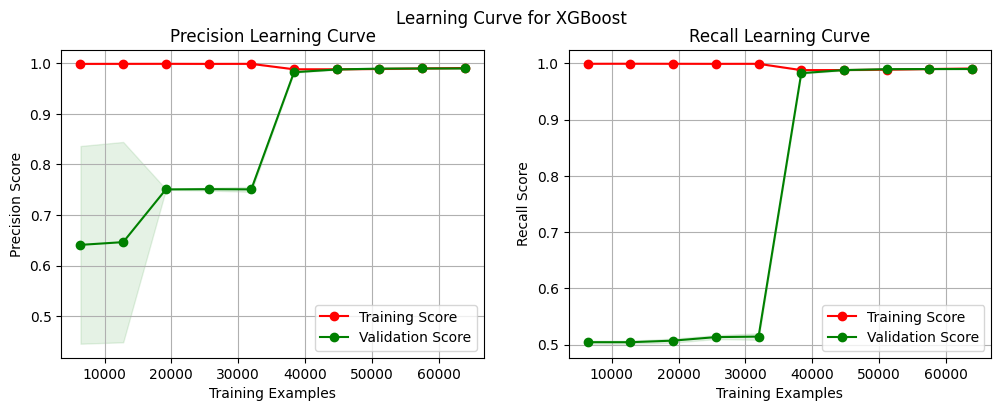

Ploting ROC-AUC and PR-AUC curves


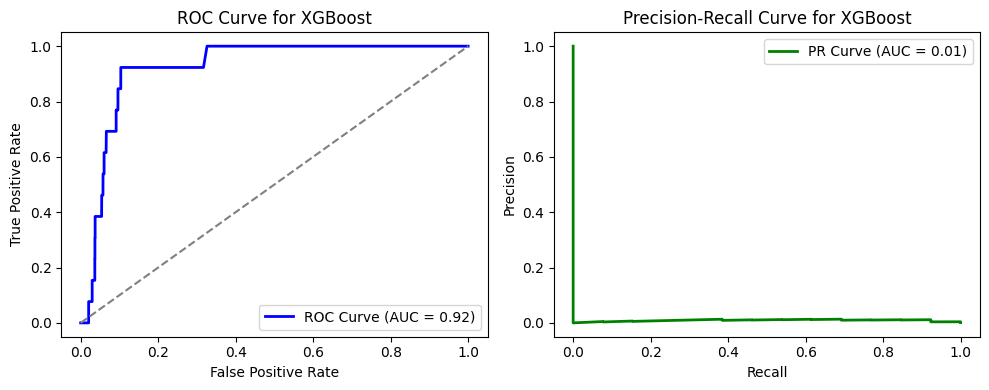



Model performance on Training Data: 
{'Random_Forest': {'Precision': 0.991448840797344, 'Recall': 0.9913286118271228, 'F1 Score': 0.9913280814485, 'Confusion Matrix': array([[39300,   659],
       [   34, 39925]])}, 'AdaBoost': {'Precision': 0.9684091886082549, 'Recall': 0.9674040891914212, 'F1 Score': 0.9673865939563829, 'Confusion Matrix': array([[37731,  2228],
       [  377, 39582]])}, 'XGBoost': {'Precision': 0.990864859354377, 'Recall': 0.9907405090217473, 'F1 Score': 0.9907399225600728, 'Confusion Matrix': array([[39271,   688],
       [   52, 39907]])}}
-----------------------------------------------------
Model performance on Test Data: 
{'Random_Forest': {'Precision': 0.9974820433873243, 'Recall': 0.9779, 'F1 Score': 0.9875515894148, 'Confusion Matrix': array([[9778,  209],
       [  12,    1]]), 'ROC-AUC': np.float64(0.7015196678759311), 'PR-AUC': np.float64(0.007202844041085739)}, 'AdaBoost': {'Precision': 0.9982919327980728, 'Recall': 0.9371, 'F1 Score': 0.96627699780319

In [9]:

"""
    Evaluating Models
    - Random_Forest
    - AdaBoost
    - XGBoost
"""

# Initialize the classifiers
models = {
    "Random_Forest": RandomForestClassifier(),
    "AdaBoost": AdaBoostClassifier(),
    # "Gradient Boosting": GradientBoostingClassifier(),
    "XGBoost": XGBClassifier()
}


# Define the hyperparameters and their possible values
params = {
    "Random_Forest": {
        'n_estimators': [50, 100, 200],
        # 'criterion': ['gini', 'entropy'],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        # 'min_samples_leaf': [1, 2, 4],
        # 'max_features': ['sqrt', 'log2', None]
    },
    "AdaBoost": {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.1, 0.5, 1.0]
        # 'algorithm': ['SAMME', 'SAMME.R']
    },
    # "Gradient Boosting": {
    #     'n_estimators': [50, 100, 200],
    #     'learning_rate': [0.01, 0.1, 0.05, 0.001],
    #     'subsample': [0.6, 0.7, 0.8, 0.9],
    #     'max_depth': [3, 5, 7, 9],
    #     'min_samples_split': [2, 5, 10],
    #     'min_samples_leaf': [1, 2, 4]
    # },
    "XGBoost": {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.1, 0.05, 0.001],
        'max_depth': [3, 5, 7, 9],
        # 'min_child_weight': [1, 3, 5],
        # 'gamma': [0, 0.1, 0.2],
        # 'subsample': [0.6, 0.7, 0.8, 0.9],
        # 'colsample_bytree': [0.6, 0.7, 0.8, 0.9]
    }
}

train_report = {}
test_report = {}
for model_name, model in models.items():
    print(f"\n================ {model_name} ==================================")

    # Initialize StratifiedKFold
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # Upsampling train data
    X_train_sm, y_train_sm = upsampling_data(X_train, y_train)

    # Initalize GridSearchCV with 5-fold stratified cross validation
    # n_jobs is set to -1, to use all available CPU cores on the machine
    # verbose=2 to track the progress grid search or model training.
    param = params[model_name]
    scoring = {
        'precision': make_scorer(precision_score, average='weighted', zero_division=0),  # Weighted precision
        'recall': make_scorer(recall_score, average='weighted', zero_division=0),        # Weighted recall
        'f1': make_scorer(f1_score, average='weighted')                # Weighted F1 score
    }
    grid_search = GridSearchCV(estimator=model, 
                                param_grid=param, 
                                cv=skf, 
                                scoring=scoring,
                                refit = 'recall',
                                n_jobs=-1, 
                                verbose=2)

    grid_search.fit(X_train_sm, y_train_sm)
    print(f"Best parameters: {grid_search.best_params_} for {model_name}")
    print(f"Best Recall score: {grid_search.best_score_}")  # Best score based on refit metric
    # Access cross-validation results for all metrics
    cv_results = grid_search.cv_results_
    print(f"Mean cross-validation precision scores: {cv_results['mean_test_precision']}")
    print(f"Mean cross-validation recall scores: {cv_results['mean_test_recall']}")
    print(f"Mean cross-validation F1 scores: {cv_results['mean_test_f1']}")

    # Set best parameters and fit the model
    model.set_params(**grid_search.best_params_)
    model.fit(X_train_sm, y_train_sm)

    # Plot learning curve
    print(f"Plotting learning curves to check model training convergence")
    plot_learning_curve(model, X_train_sm, y_train_sm, title=f"Learning Curve for {model_name}")

    # Predict on train and test data
    y_train_pred = model.predict(X_train_sm)
    y_test_pred = model.predict(X_test)
    y_test_pred_proba = model.predict_proba(X_test)[:, 1]

    # Plot ROC and PR curves
    print(f"Ploting ROC-AUC and PR-AUC curves")
    plot_roc_pr_curves(y_test, y_test_pred_proba, title_suffix=f"for {model_name}")

    # Get evaluation metrics
    precision_train, recall_train, f1_train, cm_train = model_metrics(y_train_sm, y_train_pred)
    precision_test, recall_test, f1_test, cm_test, roc_auc_test, pr_auc_test = model_metrics(y_test, y_test_pred, y_test_pred_proba)

    # Store results
    train_report[model_name] = {
        "Precision": precision_train,
        "Recall": recall_train,
        "F1 Score": f1_train,
        "Confusion Matrix": cm_train
    }
    test_report[model_name] = {
        "Precision": precision_test,
        "Recall": recall_test,
        "F1 Score": f1_test,
        "Confusion Matrix": cm_test,
        "ROC-AUC": roc_auc_test,
        "PR-AUC": pr_auc_test
        
    }
    print("=============================================================\n\n")

print(f"Model performance on Training Data: \n{train_report}")
print(f"-----------------------------------------------------")
print(f"Model performance on Test Data: \n{test_report}")

#### Models evaluation results on training data and test data

In [10]:

# Convert train_report dictionary to DataFrame
train_report_df = pd.DataFrame({
    'Model': list(train_report.keys()),  # Model names
    'Precision': [metrics['Precision'] for metrics in train_report.values()],  # Precision values
    'Recall': [metrics['Recall'] for metrics in train_report.values()],  # Recall values
    'F1 Score': [metrics['F1 Score'] for metrics in train_report.values()],  # F1 Score values
    'Confusion Matrix': [metrics['Confusion Matrix'] for metrics in train_report.values()]  # Confusion matrices
})
print(f"Model performance on Train data: ")
display(train_report_df)

# Convert test_report dictionary to DataFrame
test_report_df = pd.DataFrame({
    'Model': list(test_report.keys()),  # Model names
    'Precision': [metrics['Precision'] for metrics in test_report.values()],  # Precision values
    'Recall': [metrics['Recall'] for metrics in test_report.values()],  # Recall values
    'F1 Score': [metrics['F1 Score'] for metrics in test_report.values()],  # F1 Score values
    'Confusion Matrix': [metrics['Confusion Matrix'] for metrics in test_report.values()],  # Confusion matrices
    'ROC-AUC': [metrics['ROC-AUC'] for metrics in test_report.values()],  # ROC-AUC values
    'PR-AUC': [metrics['PR-AUC'] for metrics in test_report.values()]  # PR-AUC values
    
})
print(f"Model performance on Test data:")
display(test_report_df)


Model performance on Train data: 


,Model,Precision,Recall,F1 Score,Confusion Matrix
0,Random_Forest,0.991449,0.991329,0.991328,"[[39300, 659], [34, 39925]]"
1,AdaBoost,0.968409,0.967404,0.967387,"[[37731, 2228], [377, 39582]]"
2,XGBoost,0.990865,0.990741,0.990740,"[[39271, 688], [52, 39907]]"


Model performance on Test data:


,Model,Precision,Recall,F1 Score,Confusion Matrix,ROC-AUC,PR-AUC
0,Random_Forest,0.997482,0.9779,0.987552,"[[9778, 209], [12, 1]]",0.701520,0.007203
1,AdaBoost,0.998292,0.9371,0.966277,"[[9362, 625], [4, 9]]",0.948475,0.015648
2,XGBoost,0.997482,0.9777,0.987449,"[[9776, 211], [12, 1]]",0.922130,0.009059


In [11]:
# test_report

#### Models and its corresponding Recall score from test training report

In [12]:
# Extract recall scores from test_report
# models_recall_score = {model: metrics["Recall"] for model, metrics in test_report.items()}
# print(f"The models and their corresponding Recall score: \n{models_recall_score}")

#### Finding the best model and its score

In [13]:
# best_model_name, best_score = max(models_recall_score.items(), key=lambda item: item[1])
# print(f"Best Model name is {best_model_name} with Recall score: {best_score}")

# # Get best model
# best_model = models[best_model_name]
# print(f"Best Model: {best_model}")

In [14]:
# # Initialize the the best model 
# best_model = RandomForestClassifier(n_estimators=200)
# # Train the model on the training data
# rfc_best = best_model.fit(X_train_sm, y_train_sm)

In [15]:
# rfc_best.get_params

In [16]:
# Predict the labels for the test set
# y_pred = rfc_best.predict(X_test)
# print(y_pred)

In [17]:
# y_test_pred_proba = rfc_best.predict_proba(X_test)[:, 1]

In [18]:
# Calculate metrics for the final model
# precision_test, recall_test, f1_test, cm_test, roc_auc_test, pr_auc_test = model_metrics(y_test, y_pred, y_test_pred_proba)

# # Create a dictionary to store the final results
# result_dict = {
#     "Final Model": best_model_name,
#     "Precision": precision_test,
#     "Recall": recall_test,
#     "F1 Score": f1_test,
#     "ROC-AUC": roc_auc_test,
#     "PR-AUC": pr_auc_test,
#     "Confusion Matrix": cm_test
# }

# # Convert the dictionary to a DataFrame
# final_results = pd.DataFrame([result_dict])
# print("Final Model Performance on Test Data:")
# final_results

In [19]:
# # Predict the probabilities for the test set
# test_probabilities = rfc_best.predict_proba(X_test)[:, 1]
# print(f"Probabilities prediction of 'Is Laundering':\n {test_probabilities}")

# # Compute the ROC curve and AUC
# fpr, tpr, thresholds = roc_curve(test_probabilities, y_test)
# roc_auc = auc(fpr, tpr)

# # Plot the ROC curve
# plt.figure(figsize=(4,4))
# RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name=rfc_best).plot()
# plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
# plt.title('ROC Curve')
# plt.show()

In [20]:
# Compute the True Positive Rate (TPR) and False Positive Rate (FPR) for a specific threshold value
# desired_tpr = 0.88
# closest_threshold = thresholds[np.argmin(np.abs(tpr - desired_tpr))]
# print(f"Closet threshold to get Desired TPR of around {desired_tpr*100}%: {closest_threshold}")

# y_pred = (test_probabilities >= closest_threshold).astype(int)
# tn, fp, fn, tp = confusion_matrix(y_pred, y_test).ravel()

# fpr_cm = fp / (fp + tn)
# tpr_cm = tp / (tp + fn)
# print(f"False Positive Rate (FPR): {fpr_cm:.3f}")
# print(f"True Positive Rate (TPR): {tpr_cm:.3f}")

# disp = ConfusionMatrixDisplay.from_predictions(y_pred, y_test, cmap="Blues")
# plt.show()

# print(f"Classification report: \n {classification_report(y_pred, y_test)}")

#### 